# Lesson - Intermediate joins in SQL

Most databases have more than 2 tables, so we'll need strategies to be able to write queries to combine data from 3 or more tables.

In this lesson we'll learn some new techniques to work with the sort of databases that most businesses will use. We'll be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Like with our Factbook database, a schema diagram will help us understand the available columns and the structure of the data. Here's a schema diagram for the Chinook database:



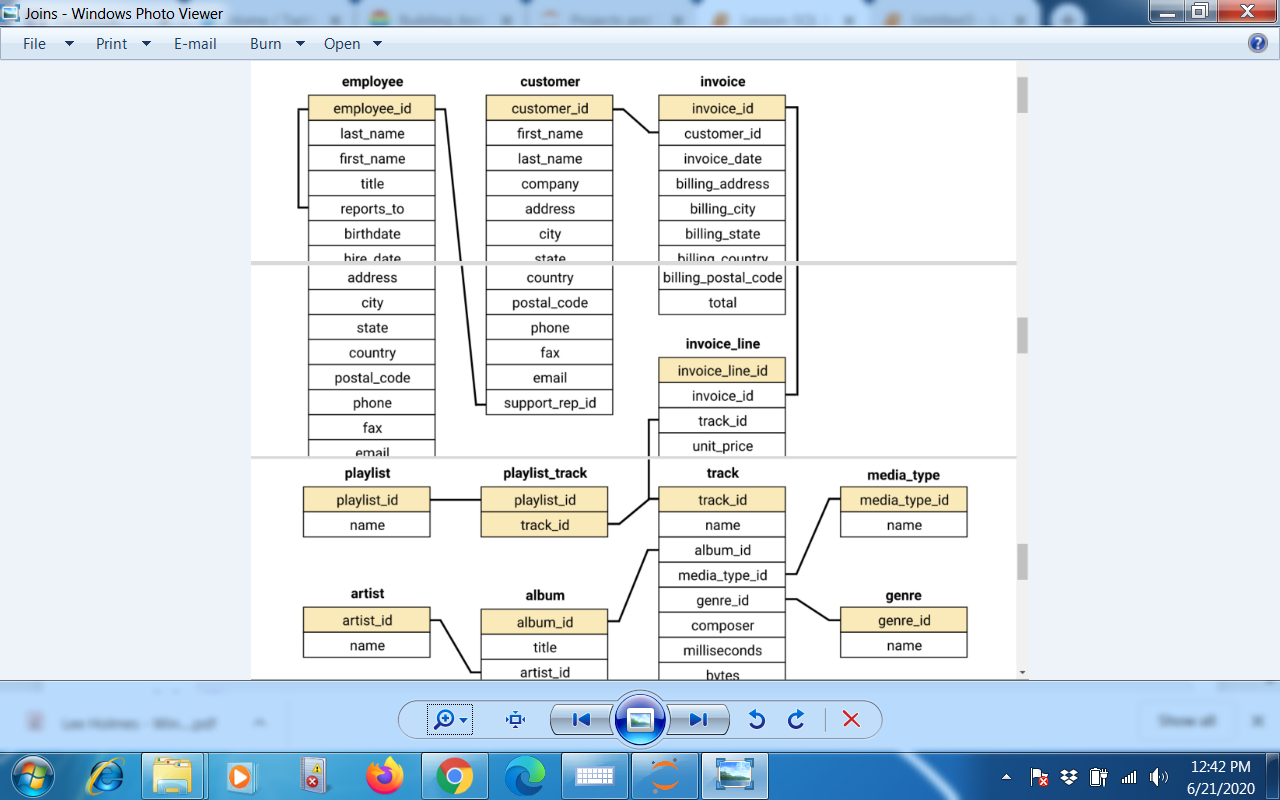

Let's take a moment to understand the different parts of the schema diagram:

Tables names are shown in bold, with the columns in each table listed below.
- Each table has one or more columns with shading, which indicates those columns are a primary key. Each row's primary key must be unique.
- Relationships between tables are shown using lines between the tables. The lines indicate which columns are related. We can notice that at least one 'end' of the relationship will be a primary key.
- 

**Load sql and connect to the Database factbook.db using following magic:**

In [ ]:
%%capture
%reload_ext sql
%sql sqlite:///chinook.db    

### Query the database to get table information for `chinook.db` directly:
**Use %%sql magic before query in each code cell to avoid returning an error 

In [ ]:
%%sql
SELECT * 
FROM sqlite_master 
WHERE type='table';

### Joining Three Tables
Write a query  that For one single purchase (invoice_id=4), for each track purchased gives:

- The id of the track.
- The name of the track.
- The name of media type of the track.
- The price that the customer paid for the track.
- The quantity of the track that was purchased.

To gather this information, we will need to write a query that joins 3 tables: `invoice_line`, `track`, and `media_type`.

In [ ]:
%%sql
PRAGMA TABLE_INFO(invoice_line)

In [ ]:
%%sql
PRAGMA TABLE_INFO(track)

In [ ]:
%%sql
PRAGMA TABLE_INFO(media_type)

Above tables are connected with keys as follows:
invoice_line - track: track_id
track - media_type: media_type_id
- We cannot join invoice_line and media_type directly as no common key exists
- We can join the three sequentially.

In [ ]:
%%sql
SELECT il.track_id, t.name AS track_name, mt.name AS track_type, il.unit_price, il.quantity
  FROM invoice_line AS il
  INNER JOIN track AS t ON t.track_id=il.track_id
  INNER JOIN media_type AS mt ON mt.media_type_id=t.media_type_id
WHERE il.invoice_id=4;  

### Joining more than Theee Tables 
If we want also the artist's name for each track. We will have to join more tables. If we examine the schema, we'll notice that the data for the artist's name is not directly connected to the track table.
Artist name is in `artist` table while `track` table is connected to `album` table which is further connected to artist table. So, if we want the artist's name in results, we will first have to join `album` table to existing join and then join `artist` table to the ensuing join.

Write a query which 
- Adds a column containing the artists name to previous query. 
- The column should be called artist_name
- The column should be placed between track_name and track_type

In [ ]:
%%sql
PRAGMA TABLE_INFO(album)

In [ ]:
%%sql
PRAGMA TABLE_INFO(artist)

In [ ]:
%%sql
SELECT il.track_id, t.name AS track_name, ar.name AS artist_name, mt.name AS track_type, il.unit_price, il.quantity
  FROM invoice_line AS il
  INNER JOIN track AS t ON t.track_id=il.track_id
  INNER JOIN media_type AS mt ON mt.media_type_id=t.media_type_id
  INNER JOIN album AS al ON al.album_id=t.album_id
  INNER JOIN artist AS ar ON ar.artist_id=al.artist_id
WHERE il.invoice_id=4;  

### Combining Multiple Joins with Subqueries
Because the invoice_line table contains each individual song from each customer purchase, it contains information about which songs are purchased the most.

We can use the table to find out which artists are purchased the most. Specifically, what we want to produce is a query that lists the top 10 artists, calculated by the number of times a track by that artist has been purchased.

In [ ]:
%%sql
SELECT *
  FROM invoice_line
WHERE invoice_id=4;    

Writing above query will only need the artist name lined up with track_id in `invoice_line` table.But that will require joining `invoice_line`, `track`, `album` and `artist`tables. We can join `album", 'artist` and `track` tables in a subquery to get `track_id` lined up with `artist_name` and then join the subquery wit `invoice_line` table to find counts of each artist's track purchases.

Write subquery first and then join with main query:

In [ ]:
%%sql
SELECT t.track_id, ar.name AS artist_name
  FROM track AS t
INNER JOIN album AS al ON al.album_id = t.album_id
INNER JOIN artist AS ar ON ar.artist_id = al.artist_id
ORDER BY 1 LIMIT 5;

In [ ]:
%%sql
SELECT
    ta.artist_name AS artist,
    COUNT(*) AS tracks_purchased
FROM invoice_line AS il
INNER JOIN (
            SELECT
                t.track_id,
                ar.name AS artist_name
            FROM track AS t
            INNER JOIN album AS al ON al.album_id = t.album_id
            INNER JOIN artist AS ar ON ar.artist_id = al.artist_id
           ) AS ta
           ON ta.track_id = il.track_id
GROUP BY 1
ORDER BY 2 DESC LIMIT 10;

Write a query:
- that returns the top 5 albums, as calculated by the number of times a track from that album has been purchased.  Query should be sorted from most tracks purchased to least tracks purchased and return the following columns, in order:
 - `album`, the title of the album
 - `artist`, the artist who produced the album
 - `tracks_purchased`, the total number of tracks purchased from that album

Writing above query will need the album and artist name lined up with track_id in `invoice_line` table.But that will require joining `invoice_line`, `track`, `album` and `artist`tables. We can join `album", 'artist` and `track` tables in a subquery to get `track_id` lined up with `album` and `artist_name`, and then join the subquery wit `invoice_line` table to find counts of each artist's track purchases.

Write subquery first and then join with main query:

In [ ]:
%%sql
PRAGMA TABLE_INFO(album)

In [ ]:
%%sql
SELECT t.track_id, al.title AS album, ar.name AS artist
  FROM track AS t
INNER JOIN album AS al ON al.album_id=t.album_id
INNER JOIN artist AS ar ON ar.artist_id=al.artist_id
ORDER BY 1
LIMIT 5;

In [ ]:
%%sql
SELECT ta.album, ta.artist, COUNT(il.track_id) AS tracks_purchased
  FROM invoice_line AS il
INNER JOIN (
            SELECT t.track_id, al.title AS album, ar.name AS artist
              FROM track AS t
            INNER JOIN album AS al ON al.album_id=t.album_id
            INNER JOIN artist AS ar ON ar.artist_id=al.artist_id
            ) AS ta ON ta.track_id=il.track_id
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 5;

### Recursive joins

In some cases, there can be a relation between two columns within the same table. We can see that in our employee table, where there is a reports_to column that has a relation to the employee_id column within the same table.

The reports_to column identifies each employee's supervisor. If we wanted to create a report of each employee and their supervisor's name, we would need some way of joining a table to itself. Doing this is called a recursive join.
```
SELECT
    e1.employee_id,
    e2.employee_id supervisor_id
FROM employee e1
INNER JOIN employee e2 on e1.reports_to = e2.employee_id
LIMIT 4;
```
To make our report more meaningful, we'll need to add some extra columns. One thing that would be nice is being able to combine the first_name and last_name columns into a single column. We can do that using the concatenate operator: ||

```
SELECT
    album_id,
    artist_id,
    "album id is" || album_id col_1,
    "artist id is" || artist_id col2,
    album_id || artist_id col3
FROM album LIMIT 3;
```
Write a query:
- that returns information about each employee and their supervisor.
- The report should include employees even if they do not report to another employee.
- The report should be sorted alphabetically by the employee_name column.
- query should return the following columns, in order:
 `employee_name` - containing the first_name and last_name columns separated by a space, eg Luke Skywalker
 `employee_title` - the title of that employee
 `supervisor_name` - the first and last name of the person the employee reports to, in the same format as employee_name
`supervisor_title` - the title of the person the employee reports to

In [ ]:
%%sql
PRAGMA TABLE_INFO(employee)

In [ ]:
%%sql
SELECT 
    e1.first_name || " " || e1.last_name AS employee_name,
    e1.title AS employee_title,
    e2.first_name || " " || e2.last_name AS supervisor_name,
    e2.title AS supervisor_title
    FROM employee AS e1
LEFt JOIN employee AS e2 ON e1.reports_to=e2.employee_id
ORDER BY 1;
    

### Pattern Matchin using `LIKE` Operator
We can use the LIKE operator to find pattern matches. The syntax for LIKE is as follows:
```
WHERE [column_name] LIKE "[pattern]"
```
Pattern should be the substring we want to match for, and one or more % characters:
`%Jen` - will match Jen at the end of a string, eg Sarah-Jen
`Jen%`- will match Jen at the start of a string, eg Jenny
`%Jen%` - will match Jen anywhere within the string, eg Kris Jenner

```
SELECT
    first_name,
    last_name,
    phone
FROM customer
WHERE first_name LIKE "%Jen%";
```
Keep in mind that in SQLite `LIKE` is case insensitive, so `LIKE "%jen%"` will match Jen and JEN and JeN. Other flavors of SQL may be case sensitive, so we may need to use the `LOWER()` function to get a case insensitive match.

Query
You have just returned from lunch to see a phone message on your desk: "Call Belle."

Write a query 
- that finds the contact details of a customer with a first_name containing Belle from the database. Your query should include the following columns, in order:
- first_name
- last_name
- phone

In [ ]:
%%sql
PRAGMA TABLE_INFO(customer)

In [ ]:
%%sql
SELECT 
    c.first_name,
    c.last_name,
    c.phone
    FROM customer AS c 
WHERE first_name LIKE "%Belle%";    

### Generating Columns with the CASE statement
Sometimes, we want to add some sort of categorization to our query. Let's say we wanted to generate a report summarizing each customer's purchases. It might be nice to create a column that puts each customer into a category:
`small spender` - If the customer's total purchases are less than $40.
`big spender` - If the customer's total purchases are greater than $100.
`regular` - If the customer's total purchases are between $40 and $100 (inclusive).

To achieve this, we'll need to use the case statement. The case statement acts like a series of if/then options for a new column. The syntax for CASE is:
```
CASE
    WHEN [comparison_1] THEN [value_1]
    WHEN [comparison_2] THEN [value_2]
    ELSE [value_3]
    END
    AS [new_column_name]
 ```
There can be 1 or more `WHEN` lines, and the `ELSE` line is optional— without it, rows that don't match any `WHEN` will be assigned a null value.  
We can't use `aliases` in the `WHEN` line, so when writing a `CASE` statement that deals with aggregate functions, we will need to include the aggregate function in each `WHEN` line.

Write a query:
- that summarizes the purchases of each customer. 
Query should include the following columns, in order:
- `customer_name` - containing the first_name and last_name columns separated by a space, eg Luke Skywalker
- `number_of_purchases`, counting the number of purchases made by each customer.
- `total_spent` - the total sum of money spent by each customer.
- `customer_category` - a column that categorizes the customer based on their total purchases. The column should contain the following values:
 - `small spender` - If the customer's total purchases are less than $40.
 - `big spender` - If the customer's total purchases are greater than $100.
- `regular` - If the customer's total purchases are between $40 and $100 (inclusive).
Order your results by the `customer_name` column.
 
 
For above query, we need customer info (`customer_name` and `customer_id`) from `customer` table, invoice info (`invoice_id`, `total` and `customer_id`) from `invoice` table, and customer_category from `CASE` statement.

In [ ]:
%%sql
SELECT * 
FROM sqlite_master 
WHERE type='table';
    

In [ ]:
%%sql
SELECT
   c.first_name || " " || c.last_name AS customer_name,
   COUNT(i.invoice_id) AS number_of_purchases,
   ROuND(SUM(i.total),2) AS total_spent,
   CASE
       WHEN sum(i.total) < 40 THEN 'small spender'
       WHEN sum(i.total) > 100 THEN 'big spender'
       ELSE 'regular'
       END
       AS customer_category
FROM invoice i
INNER JOIN customer AS c ON i.customer_id = c.customer_id
GROUP BY 1 
ORDER BY 1;
    